In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Importing Scaling and Encoding tools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Importing necessary diagnostics tools
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Importing Models to be used
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression

In [2]:
os.chdir("C://Users//lenovo//Desktop//ML//Classification proj//")
df = pd.read_csv("clean_df2.csv")

In [3]:
### Step 1: 
## In this dataset, all fields are collected from January 2018.
## So the month and year components are constant all throughout and thus yield no information and can be removed.
## The hour that the booking was made already exists in a "hours" column.
## The day of the pickup and dropoff can be preserved in different new fields.
## In case the dataset is extended to include different months/years, we can add more columns with those components.

df["pickup_day"] = df["lpep_pickup_datetime"].map(lambda x: dt.datetime.fromisoformat(x).day)
df["dropoff_day"] = df["lpep_dropoff_datetime"].map(lambda x: dt.datetime.fromisoformat(x).day)

df.drop(columns=["lpep_pickup_datetime", "lpep_dropoff_datetime"], inplace=True)

In [4]:
### Step 2: Discretize the proces into ranges
## In order to judge the relative cost of a trip, we have chosen the price per km as a metric.
## Using the data we already have, we calculate the price/total_distance and find the 33, 67 and 100 quantiles
## to correspond to the Low, Medium and High categories, respectively.

# If a trip has a distance of 0km, replace it with a 0.01km trip.
df_ind = np.where(df["trip_distance"] == 0)[0]
df.loc[df_ind, "trip_distance"] = 0.01
del df_ind

price_per_km = df["total_amount"]/df["trip_distance"]

quan33 = price_per_km.quantile(0.33)
quan67 = price_per_km.quantile(0.67)
quan100 = price_per_km.quantile(1.0)

df_ind_33 = np.where(price_per_km <= quan33)[0]
df_ind_67 = np.where(np.logical_and(quan33 < price_per_km, price_per_km <= quan67))[0]
df_ind_100 = np.where(np.logical_and(quan67 < price_per_km, price_per_km <= quan100))[0]

df.loc[df_ind_33, "price_per_km"] = "LOW"
df.loc[df_ind_67, "price_per_km"] = "MEDIUM"
df.loc[df_ind_100, "price_per_km"] = "HIGH"
del df_ind_33, df_ind_67, df_ind_100, price_per_km

# Drop rows pertaining to the amount paid that depend on the trip.
df.drop(columns=["total_amount", "fare_amount", "mta_tax", "tip_amount"], inplace=True)

In [5]:
### Step 3: Split the dataset into Train and Test sets.

x_train = df.sample(frac=0.8)
x_test = df.drop(x_train.index).sample(frac=1.0)
del df

y_train = x_train["price_per_km"]
y_test = x_test["price_per_km"]

x_train = x_train.drop(columns=["price_per_km"])
x_test = x_test.drop(columns=["price_per_km"])

num_train = len(x_train)

In [6]:
### Step 4: Scale the dataset
## Once using a standard scaler, once using a minmax scaler
## Now we have 3 versions of the dataset: Unscaled, Standard, Minmax

x = np.concatenate((x_train, x_test), axis = 0)
scaler_standard = StandardScaler()
x_std = scaler_standard.fit_transform(x)
x_std_train = x_std[:num_train,:]
x_std_test = x_std[num_train:,:]
del x_std

scaler_minmax = MinMaxScaler()
x_minmax = scaler_minmax.fit_transform(x)
x_minmax_train = x_minmax[:num_train,:]
x_minmax_test = x_minmax[num_train:,:]
del x_minmax

del x

In [7]:
### Step 5: Encode the labels in the Test set (Low, Medium, High)

y = np.concatenate((y_train, y_test), axis = 0)
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y_train = y[:num_train]
y_test = y[num_train:]

del y

# Helper Functions

In [8]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    
    Takes a GridSearchCV object and loops over the parameters to plot the confidence interval of each value.
    For each value in a feature, the rest of the parameters are fixed to the ones defined by the best accuracy.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    if len(masks_names) == 1:
        plt.figure(figsize=(20,5))
        x = np.array(params[masks_names[0]])
        if None in x:
            x[x == None] = "None"
        y_1 = np.array(means_test)
        e_1 = np.array(stds_test)
        plt.errorbar(x, y_1, e_1, linestyle='--', marker='o')
        plt.xlabel(masks_names[0].title())

    else:
        plt.figure(figsize=(20,5))
        for i, p in enumerate(masks_names):
            plt.subplot(int(np.ceil(len(params)/2)), 2, i+1)
            m = np.stack(masks[:i] + masks[i+1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            if None in x:
                x[x == None] = "None"
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            plt.errorbar(x, y_1, e_1, linestyle='--', marker='o')
            plt.xlabel(p.title())
            plt.grid(True)
            if i%2==0: plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

# K-Nearest Neighbours (KNN)

In [9]:
n_neighbors=10
n_splits=5
knn_model = knn(n_jobs=-1, n_neighbors=n_neighbors)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(knn_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(knn_model, x_train, y_train, cv=cv_strat_kfold)
knn_unscaled_res = knn_model.fit(x_train, y_train).score(x_test, y_test)
print(f"KNN using k={n_neighbors} and no scaling. Accuracy: {knn_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(knn_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(knn_model, x_std_train, y_train, cv=cv_strat_kfold)
knn_std_res = knn_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"KNN using k={n_neighbors} and standard scaling. Accuracy: {knn_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(knn_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(knn_model, x_minmax_train, y_train, cv=cv_strat_kfold)
knn_minmax_res = knn_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"KNN using k={n_neighbors} and minmax scaling. Accuracy: {knn_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

KNN using k=10 and no scaling. Accuracy: 71.91%
Cross Validation using KFold Sampling Mean: 0.71 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.71 with std 0.00

KNN using k=10 and standard scaling. Accuracy: 79.24%
Cross Validation using KFold Sampling Mean: 0.79 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.79 with std 0.00

KNN using k=10 and minmax scaling. Accuracy: 65.64%
Cross Validation using KFold Sampling Mean: 0.65 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.65 with std 0.00


In [10]:
n_neighbors=int(np.sqrt(num_train))
n_splits=3
knn_model = knn(n_jobs=-1, n_neighbors=n_neighbors)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(knn_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(knn_model, x_train, y_train, cv=cv_strat_kfold)
knn_unscaled_res = knn_model.fit(x_train, y_train).score(x_test, y_test)
print(f"KNN using k={n_neighbors} and no scaling. Accuracy: {knn_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(knn_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(knn_model, x_std_train, y_train, cv=cv_strat_kfold)
knn_std_res = knn_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"KNN using k={n_neighbors} and standard scaling. Accuracy: {knn_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(knn_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(knn_model, x_minmax_train, y_train, cv=cv_strat_kfold)
knn_minmax_res = knn_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"KNN using k={n_neighbors} and minmax scaling. Accuracy: {knn_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

KNN using k=795 and no scaling. Accuracy: 58.62%
Cross Validation using KFold Sampling Mean: 0.57 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.57 with std 0.00

KNN using k=795 and standard scaling. Accuracy: 72.43%
Cross Validation using KFold Sampling Mean: 0.71 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.71 with std 0.00

KNN using k=795 and minmax scaling. Accuracy: 54.50%
Cross Validation using KFold Sampling Mean: 0.53 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.53 with std 0.00


### No Scaling

Highest Accuracy achieved at K = 9 with no scaling. Accuracy 74.61%


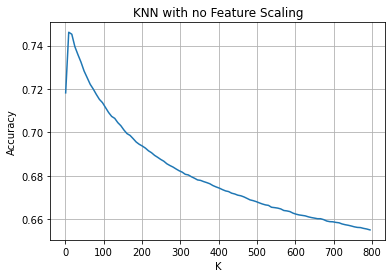

In [ ]:
num_test_k_values = 100
n_neighbors_list = np.linspace(1,int(np.sqrt(num_train)), num_test_k_values, dtype=int)
knn_unscaled_res_list = np.zeros(num_test_k_values)
for i in range(num_test_k_values):
    n_neighbors = n_neighbors_list[i]
    knn_unscaled_res_list[i] = knn(n_jobs=-1, n_neighbors=n_neighbors).fit(x_train, y_train).score(x_test, y_test)

max_index = np.argmax(knn_unscaled_res_list)
print(f"Highest Accuracy achieved at K = {n_neighbors_list[max_index]} with no scaling. Accuracy {knn_unscaled_res_list[max_index]*100:.2f}%")
plt.figure()
plt.plot(n_neighbors_list, knn_unscaled_res_list)
plt.grid(True)
plt.title("KNN with no Feature Scaling")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

Best Parameters achieved at:
 - metric = manhattan
 - n_neighbors = 10
 - weights = distance
with no scaling. Accuracy 71.98%


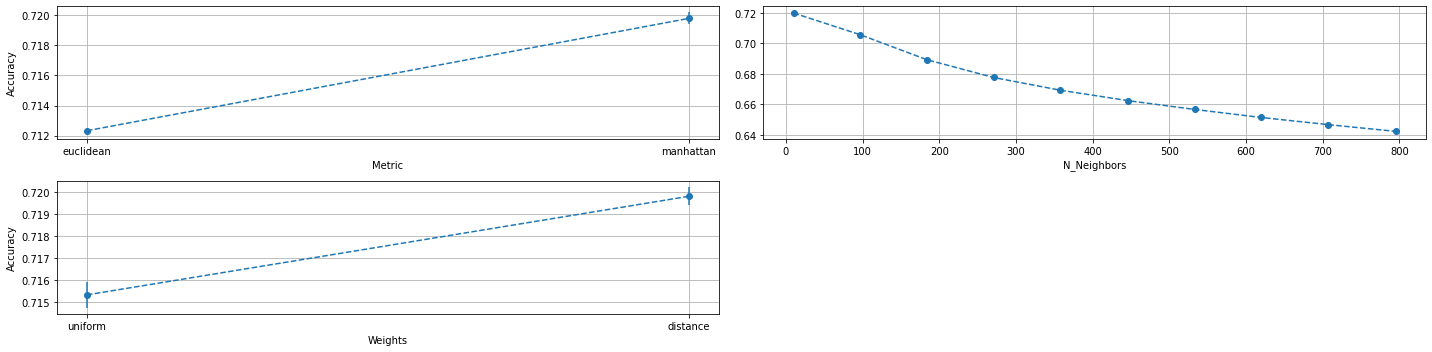

In [14]:
num_test_k_values = 10
n_neighbors = np.linspace(10,int(np.sqrt(num_train)), num_test_k_values, dtype=int)
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]
knn_model = knn(n_jobs=-1)
search_params = {"n_neighbors":n_neighbors, "weights": weights, "metric": metric}
knn_unscaled_res = GridSearchCV(knn_model, search_params, n_jobs=3, verbose=1, cv=3).fit(x_train, y_train)

print("Best Parameters achieved at:")
for k,v in knn_unscaled_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {knn_unscaled_res.best_score_*100:.2f}%")
plot_search_results(knn_unscaled_res)

In [15]:
n_neighbors = knn_unscaled_res.best_params_["n_neighbors"]
weights = knn_unscaled_res.best_params_["weights"]
metric = knn_unscaled_res.best_params_["metric"]
knn_model = knn(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=-1).fit(x_train, y_train)
knn_unscaled_res_train = knn_model.score(x_train, y_train)
knn_unscaled_res_test = knn_model.score(x_test, y_test)
print(f"KNN using K = {n_neighbors}, {weights} weights, {metric} metric and no scaling.")
print(f"Training Set Accuracy: {knn_unscaled_res_train*100:.2f}%")
print(f"Test Set Accuracy: {knn_unscaled_res_test*100:.2f}%")

KNN using K = 10, distance weights, manhattan metric and no scaling.
Training Set Accuracy: 99.92%
Test Set Accuracy: 73.21%


### Standard Scaling

Unfortunately, KNN demands a significant amount of computational runtime, so we could not quite perform tuning of parameters using the scaled dataset.
Instead, we use the best parameters for the unscaled dataset on the scaled dataset and evaluate the performance.

In [ ]:
num_test_k_values = 10
n_neighbors = np.linspace(10,int(np.sqrt(num_train)), num_test_k_values, dtype=int)
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]
knn_model = knn(n_jobs=-1)
search_params = {"n_neighbors":n_neighbors, "weights": weights, "metric": metric}
knn_std_res = GridSearchCV(knn_model, search_params, n_jobs=3, verbose=1, cv=3).fit(x_std_train, y_train)

print("Best Parameters achieved at:")
for k,v in knn_std_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {knn_std_res.best_score_*100:.2f}%")
plot_search_results(knn_std_res)

In [9]:
n_neighbors = 10#knn_std_res.best_params_["n_neighbors"]
weights = "distance"#knn_std_res.best_params_["weights"]
metric = "manhattan"#knn_std_res.best_params_["metric"]
knn_model = knn(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=-1).fit(x_std_train, y_train)
knn_std_res_train = knn_model.score(x_std_train, y_train)
knn_std_res_test = knn_model.score(x_std_test, y_test)
print(f"KNN using K = {n_neighbors}, {weights} weights, {metric} metric and Standard scaling.")
print(f"Training Set Accuracy: {knn_std_res_train*100:.2f}%")
print(f"Test Set Accuracy: {knn_std_res_test*100:.2f}%")

KNN using K = 10, distance weights, manhattan metric and Standard scaling.
Training Set Accuracy: 99.92%
Test Set Accuracy: 79.32%


### Minmax Scaling

Unfortunately, KNN demands a significant amount of computational runtime, so we could not quite perform tuning of parameters using the scaled dataset.
Instead, we use the best parameters for the unscaled dataset on the scaled dataset and evaluate the performance.

In [ ]:
num_test_k_values = 10
n_neighbors = np.linspace(10,int(np.sqrt(num_train)), num_test_k_values, dtype=int)
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan"]
knn_model = knn(n_jobs=-1)
search_params = {"n_neighbors":n_neighbors, "weights": weights, "metric": metric}
knn_minmax_res = GridSearchCV(knn_model, search_params, n_jobs=3, verbose=1, cv=3).fit(x_minmax_train, y_train)

print("Best Parameters achieved at:")
for k,v in knn_minmax_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {knn_minmax_res.best_score_*100:.2f}%")
plot_search_results(knn_minmax_res)

In [10]:
n_neighbors = 10#knn_std_res.best_params_["n_neighbors"]
weights = "distance"#knn_std_res.best_params_["weights"]
metric = "manhattan"#knn_std_res.best_params_["metric"]
knn_model = knn(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=-1).fit(x_minmax_train, y_train)
knn_minmax_res_train = knn_model.score(x_minmax_train, y_train)
knn_minmax_res_test = knn_model.score(x_minmax_test, y_test)
print(f"KNN using K = {n_neighbors}, {weights} weights, {metric} metric and Minmax scaling.")
print(f"Training Set Accuracy: {knn_minmax_res_train*100:.2f}%")
print(f"Test Set Accuracy: {knn_minmax_res_test*100:.2f}%")

KNN using K = 10, distance weights, manhattan metric and Minmax scaling.
Training Set Accuracy: 99.92%
Test Set Accuracy: 68.81%


# Decision Trees

In [30]:
n_splits=5
max_depth=10
dtc_model = DecisionTreeClassifier(max_depth=max_depth)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(dtc_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(dtc_model, x_train, y_train, cv=cv_strat_kfold)
dtc_unscaled_res = dtc_model.fit(x_train, y_train).score(x_test, y_test)
print(f"Decision Tree Classifier using {max_depth} max depth and no scaling. Accuracy: {dtc_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(dtc_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(dtc_model, x_std_train, y_train, cv=cv_strat_kfold)
dtc_std_res = dtc_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"Decision Tree Classifier using {max_depth} max depth and standard scaling. Accuracy: {dtc_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(dtc_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(dtc_model, x_minmax_train, y_train, cv=cv_strat_kfold)
dtc_minmax_res = dtc_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"Decision Tree Classifier using {max_depth} max depth and minmax scaling. Accuracy: {dtc_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

Decision Tree Classifier using 10 max depth and no scaling. Accuracy: 82.75%
Cross Validation using KFold Sampling Mean: 0.83 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.83 with std 0.00

Decision Tree Classifier using 10 max depth and standard scaling. Accuracy: 82.75%
Cross Validation using KFold Sampling Mean: 0.83 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.83 with std 0.00

Decision Tree Classifier using 10 max depth and minmax scaling. Accuracy: 82.75%
Cross Validation using KFold Sampling Mean: 0.83 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.83 with std 0.00


### No Scaling

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 12
 - max_features = None
with no scaling. Accuracy 82.80%


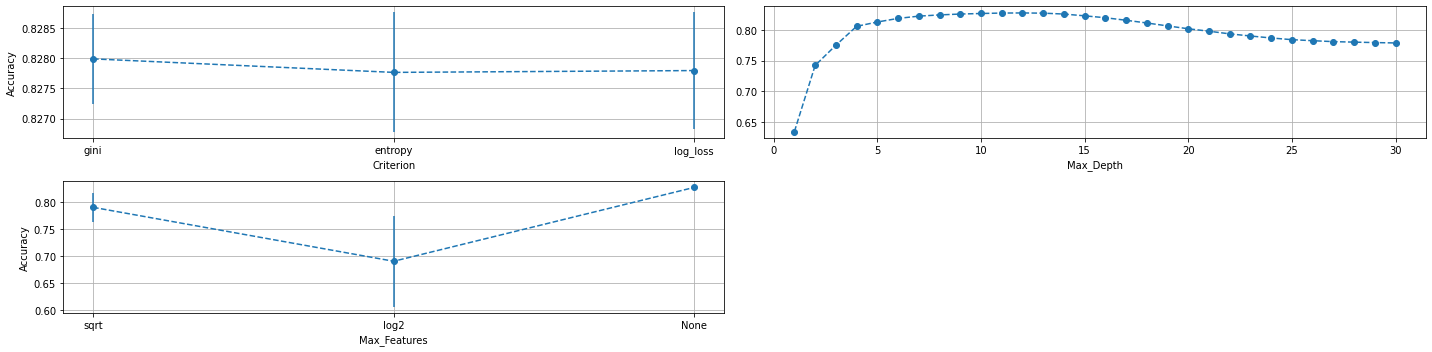

In [ ]:
num_test_max_depth_values = 30
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
dtc_model = DecisionTreeClassifier()
search_params = {"max_depth":max_depth, "criterion":criterion, "max_features":max_features}
dtc_unscaled_res = GridSearchCV(dtc_model, search_params, n_jobs=10, verbose=1).fit(x_train, y_train)

print("Best Parameters achieved at:")
for k,v in dtc_unscaled_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {dtc_unscaled_res.best_score_*100:.2f}%")
plot_search_results(dtc_unscaled_res)

In [34]:
criterion = dtc_unscaled_res.best_params_["criterion"]
max_depth = dtc_unscaled_res.best_params_["max_depth"]
max_features = dtc_unscaled_res.best_params_["max_features"]
dtc_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features).fit(x_train, y_train)
dtc_unscaled_res_train = dtc_model.score(x_train, y_train)
dtc_unscaled_res_test = dtc_model.score(x_test, y_test)
print(f"Decision Tree Classifier using {criterion} criterion, {max_depth} max depth, {max_features} max features and no scaling.")
print(f"Training Set Accuracy: {dtc_unscaled_res_train*100:.2f}%")
print(f"Test Set Accuracy: {dtc_unscaled_res_test*100:.2f}%")

Decision Tree Classifier using gini criterion, 12 max depth, None max features and no scaling.
Training Set Accuracy: 83.83%
Test Set Accuracy: 82.98%


### Standard Scaling

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 12
 - max_features = None
with Standard scaling. Accuracy 82.80%


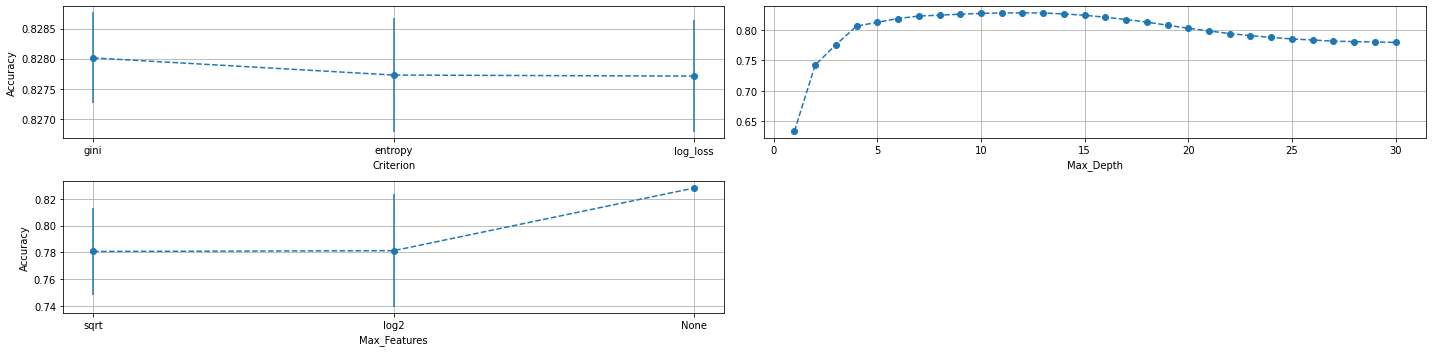

In [19]:
num_test_max_depth_values = 30
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
dtc_model = DecisionTreeClassifier()
search_params = {"max_depth":max_depth, "criterion":criterion, "max_features":max_features}
dtc_std_res = GridSearchCV(dtc_model, search_params, n_jobs=10, verbose=1).fit(x_std_train, y_train)

print("Best Parameters achieved at:")
for k,v in dtc_std_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Standard scaling. Accuracy {dtc_std_res.best_score_*100:.2f}%")
plot_search_results(dtc_std_res)

In [20]:
criterion = dtc_std_res.best_params_["criterion"]
max_depth = dtc_std_res.best_params_["max_depth"]
max_features = dtc_std_res.best_params_["max_features"]
dtc_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features).fit(x_std_train, y_train)
dtc_std_res_train = dtc_model.score(x_std_train, y_train)
dtc_std_res_test = dtc_model.score(x_std_test, y_test)
print(f"Decision Tree Classifier using {criterion} criterion, {max_depth} max depth, {max_features} max features and Standard scaling.")
print(f"Training Set Accuracy: {dtc_std_res_train*100:.2f}%")
print(f"Test Set Accuracy: {dtc_std_res_test*100:.2f}%")

Decision Tree Classifier using gini criterion, 12 max depth, None max features and Standard scaling.
Training Set Accuracy: 83.80%
Test Set Accuracy: 82.91%


### Minmax Scaling

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 12
 - max_features = None
with Minmax scaling. Accuracy 82.80%


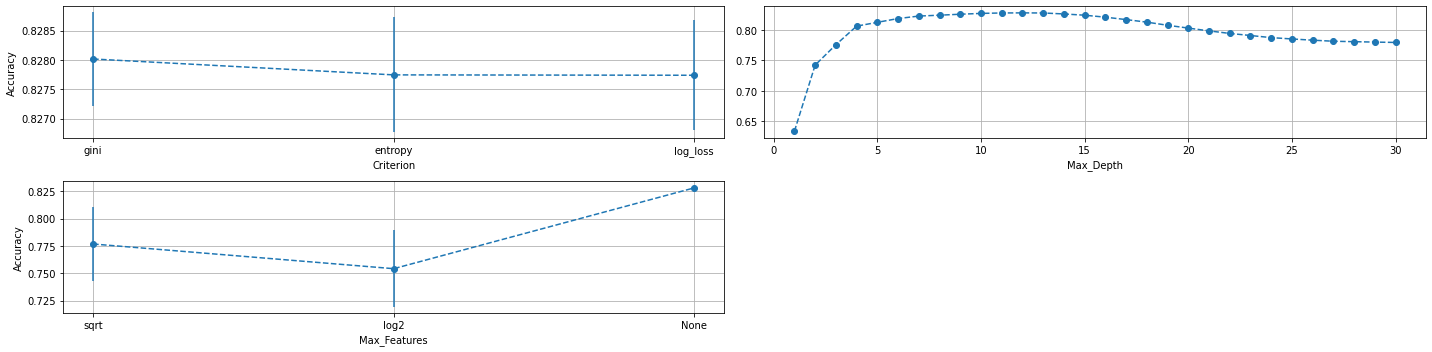

In [22]:
num_test_max_depth_values = 30
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
dtc_model = DecisionTreeClassifier()
search_params = {"max_depth":max_depth, "criterion":criterion, "max_features":max_features}
dtc_minmax_res = GridSearchCV(dtc_model, search_params, n_jobs=10, verbose=1).fit(x_minmax_train, y_train)

print("Best Parameters achieved at:")
for k,v in dtc_minmax_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Minmax scaling. Accuracy {dtc_minmax_res.best_score_*100:.2f}%")
plot_search_results(dtc_minmax_res)

In [23]:
criterion = dtc_minmax_res.best_params_["criterion"]
max_depth = dtc_minmax_res.best_params_["max_depth"]
max_features = dtc_minmax_res.best_params_["max_features"]
dtc_model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_features=max_features).fit(x_minmax_train, y_train)
dtc_minmax_res_train = dtc_model.score(x_minmax_train, y_train)
dtc_minmax_res_test = dtc_model.score(x_minmax_test, y_test)
print(f"Decision Tree Classifier using {criterion} criterion, {max_depth} max depth, {max_features} max features and Minmax scaling.")
print(f"Training Set Accuracy: {dtc_minmax_res_train*100:.2f}%")
print(f"Test Set Accuracy: {dtc_minmax_res_test*100:.2f}%")

Decision Tree Classifier using gini criterion, 12 max depth, None max features and Minmax scaling.
Training Set Accuracy: 83.80%
Test Set Accuracy: 82.91%


# Random Forest

In [24]:
n_splits=5
n_estimators=3
rfc_model = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(rfc_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(rfc_model, x_train, y_train, cv=cv_strat_kfold)
rfc_unscaled_res = rfc_model.fit(x_train, y_train).score(x_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees and no scaling. Accuracy: {rfc_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(rfc_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(rfc_model, x_std_train, y_train, cv=cv_strat_kfold)
rfc_std_res = rfc_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees and Standard scaling. Accuracy: {rfc_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(rfc_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(rfc_model, x_minmax_train, y_train, cv=cv_strat_kfold)
rfc_minmax_res = rfc_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees and Minmax scaling. Accuracy: {rfc_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

Random Forest Classifier using 3 trees and no scaling. Accuracy: 93.96%
Random Forest Classifier using 3 trees and standard scaling. Accuracy: 94.46%
Random Forest Classifier using 3 trees and minmax scaling. Accuracy: 94.65%


In [26]:
n_splits=5
n_estimators=3
max_depth=10
rfc_model = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(rfc_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(rfc_model, x_train, y_train, cv=cv_strat_kfold)
rfc_unscaled_res = rfc_model.fit(x_train, y_train).score(x_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} max depth and no scaling. Accuracy: {rfc_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(rfc_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(rfc_model, x_std_train, y_train, cv=cv_strat_kfold)
rfc_std_res = rfc_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} max depth and Standard scaling. Accuracy: {rfc_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(rfc_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(rfc_model, x_minmax_train, y_train, cv=cv_strat_kfold)
rfc_minmax_res = rfc_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} max depth and Minmax scaling. Accuracy: {rfc_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

Random Forest Classifier using 3 trees and no scaling. Accuracy: 88.08%
Random Forest Classifier using 3 trees and standard scaling. Accuracy: 87.09%
Random Forest Classifier using 3 trees and minmax scaling. Accuracy: 81.38%


### No Scaling

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 10
 - max_features = None
 - n_estimators = 67
with no scaling. Accuracy 83.08%


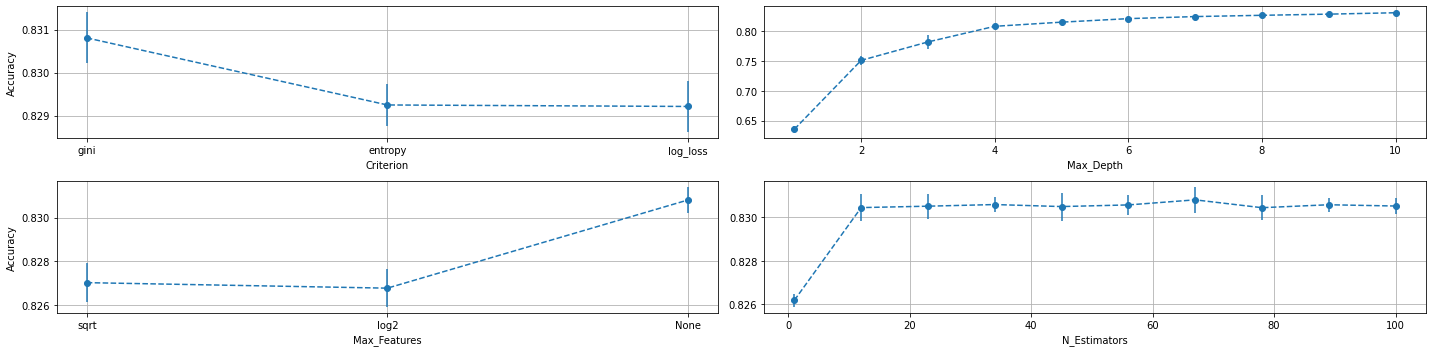

In [9]:
num_test_estimators_values = 10
num_test_max_depth_values = 10
n_estimators = np.linspace(1,100, num_test_estimators_values, dtype=int)
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
rfc_model = RandomForestClassifier(n_jobs=-1)
search_params = {"n_estimators":n_estimators, "max_depth":max_depth, "criterion":criterion, "max_features":max_features}
rfc_unscaled_res = GridSearchCV(rfc_model, search_params, n_jobs=3, verbose=1).fit(x_train, y_train)

print("Best Parameters achieved at:")
for k,v in rfc_unscaled_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {rfc_unscaled_res.best_score_*100:.2f}%")
plot_search_results(rfc_unscaled_res)

In [14]:
n_estimators = rfc_unscaled_res.best_params_["n_estimators"]
criterion = rfc_unscaled_res.best_params_["criterion"]
max_depth = rfc_unscaled_res.best_params_["max_depth"]
rfc_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=None, n_jobs=-1)
rfc_model.fit(x_train, y_train)
train_score = rfc_model.score(x_train, y_train)
test_score = rfc_model.score(x_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} maximum depth, {criterion} criterion and no scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

Random Forest Classifier using 67 trees, 10 maximum depth, gini criterion and no scaling.
Training Set Accuracy: 83.35%
Test Set Accuracy: 83.02%


### Standard Scaling

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 5
 - max_features = None
 - n_estimators = 25
with Standard scaling. Accuracy 81.33%


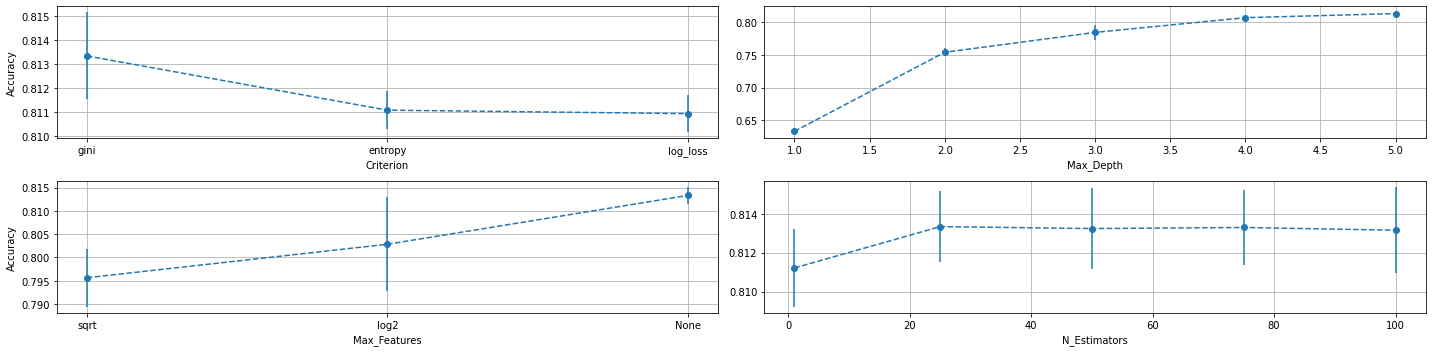

In [13]:
num_test_estimators_values = 5
num_test_max_depth_values = 5
n_estimators = np.linspace(1,100, num_test_estimators_values, dtype=int)
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
rfc_model = RandomForestClassifier(n_jobs=-1)
search_params = {"n_estimators":n_estimators, "max_depth":max_depth, "criterion":criterion, "max_features":max_features}
rfc_std_res = GridSearchCV(rfc_model, search_params, n_jobs=3, verbose=1, cv=3).fit(x_std_train, y_train)

print("Best Parameters achieved at:")
for k,v in rfc_std_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Standard scaling. Accuracy {rfc_std_res.best_score_*100:.2f}%")
plot_search_results(rfc_std_res)

In [14]:
n_estimators = rfc_std_res.best_params_["n_estimators"]
criterion = rfc_std_res.best_params_["criterion"]
max_depth = rfc_std_res.best_params_["max_depth"]
rfc_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=None, n_jobs=-1)
rfc_model.fit(x_std_train, y_train)
train_score = rfc_model.score(x_std_train, y_train)
test_score = rfc_model.score(x_std_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} maximum depth, {criterion} criterion and Standard scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

Random Forest Classifier using 25 trees, 5 maximum depth, gini criterion and Standard scaling.
Training Set Accuracy: 81.19%
Test Set Accuracy: 81.18%


### Minmax Scaling

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Parameters achieved at:
 - criterion = gini
 - max_depth = 5
 - max_features = None
 - n_estimators = 75
with Minmax scaling. Accuracy 81.42%


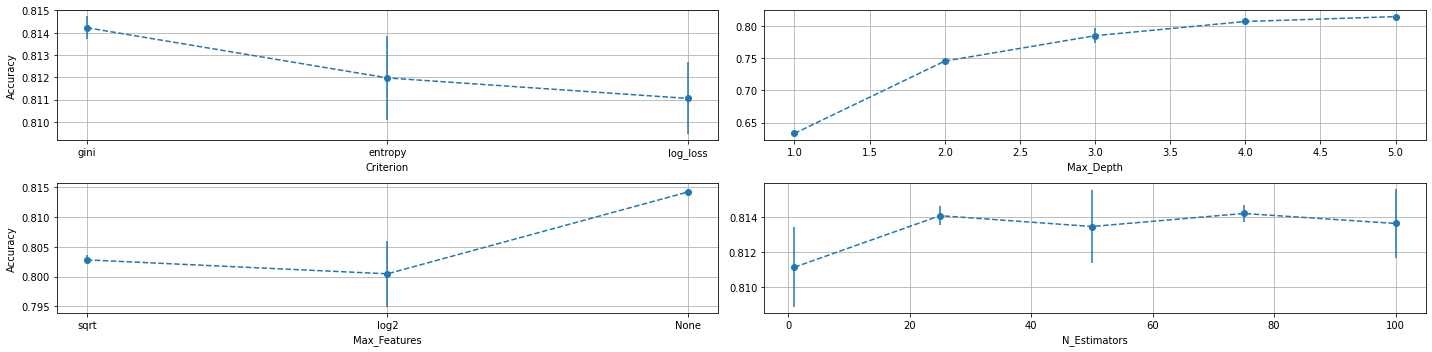

In [12]:
num_test_estimators_values = 5
num_test_max_depth_values = 5
n_estimators = np.linspace(1,100, num_test_estimators_values, dtype=int)
max_depth = np.arange(1,num_test_max_depth_values+1)
criterion = ["gini", "entropy", "log_loss"]
max_features = ["sqrt", "log2", None]
rfc_model = RandomForestClassifier(n_jobs=-1)
search_params = {"n_estimators":n_estimators, "max_depth":max_depth, "criterion":criterion, "max_features":max_features}
rfc_minmax_res = GridSearchCV(rfc_model, search_params, n_jobs=3, verbose=1, cv=3).fit(x_minmax_train, y_train)

print("Best Parameters achieved at:")
for k,v in rfc_minmax_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Minmax scaling. Accuracy {rfc_minmax_res.best_score_*100:.2f}%")
plot_search_results(rfc_minmax_res)

In [15]:
n_estimators = rfc_minmax_res.best_params_["n_estimators"]
criterion = rfc_minmax_res.best_params_["criterion"]
max_depth = rfc_minmax_res.best_params_["max_depth"]
rfc_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, max_features=None, n_jobs=-1)
rfc_model.fit(x_minmax_train, y_train)
train_score = rfc_model.score(x_minmax_train, y_train)
test_score = rfc_model.score(x_minmax_test, y_test)
print(f"Random Forest Classifier using {n_estimators} trees, {max_depth} maximum depth, {criterion} criterion and Minmax scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

Random Forest Classifier using 75 trees, 5 maximum depth, gini criterion and Minmax scaling.
Training Set Accuracy: 81.50%
Test Set Accuracy: 81.50%


# Naive Bayes

### Gaussian Naive Bayes

In [28]:
n_splits=5
gnb_model = GaussianNB()
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(gnb_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(gnb_model, x_train, y_train, cv=cv_strat_kfold)
gnb_model.fit(x_train, y_train)
gnb_unscaled_res_train = gnb_model.score(x_train, y_train)
gnb_unscaled_res_test = gnb_model.score(x_test, y_test)
print("Gaussian Naive Bayes with no scaling.")
print(f"Train Set Accuracy: {gnb_unscaled_res_train*100:.2f}%")
print(f"Test Set Accuracy: {gnb_unscaled_res_test*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

cv_kfold_std_res = cross_val_score(gnb_model, x_std_train, y_train, cv=cv_kfold)
cv_strat_kfold_std_res = cross_val_score(gnb_model, x_std_train, y_train, cv=cv_strat_kfold)
gnb_model.fit(x_std_train, y_train)
gnb_std_res_train = gnb_model.score(x_std_train, y_train)
gnb_std_res_test = gnb_model.score(x_std_test, y_test)
print("Gaussian Naive Bayes with Standard scaling.")
print(f"Train Set Accuracy: {gnb_std_res_train*100:.2f}%")
print(f"Test Set Accuracy: {gnb_std_res_test*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

cv_kfold_minmax_res = cross_val_score(gnb_model, x_minmax_train, y_train, cv=cv_kfold)
cv_strat_kfold_minmax_res = cross_val_score(gnb_model, x_minmax_train, y_train, cv=cv_strat_kfold)
gnb_model.fit(x_minmax_train, y_train)
gnb_minmax_res_train = gnb_model.score(x_minmax_train, y_train)
gnb_minmax_res_test = gnb_model.score(x_minmax_test, y_test)
print("Gaussian Naive Bayes with Minmax scaling.")
print(f"Train Set Accuracy: {gnb_minmax_res_train*100:.2f}%")
print(f"Test Accuracy: {gnb_minmax_res_test*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

Gaussian Naive Bayes with no scaling.
Train Set Accuracy: 49.68%
Test Set Accuracy: 49.58%
Cross Validation using KFold Sampling Mean: 0.50 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.50 with std 0.00

Gaussian Naive Bayes with Standard scaling.
Train Set Accuracy: 49.68%
Test Set Accuracy: 49.58%
Cross Validation using KFold Sampling Mean: 0.50 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.50 with std 0.00

Gaussian Naive Bayes with Minmax scaling.
Train Set Accuracy: 49.68%
Test Accuracy: 49.58%
Cross Validation using KFold Sampling Mean: 0.50 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.50 with std 0.00


In [30]:
gnb_model.fit(x_train, y_train)
y_pred = gnb_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=list(labelencoder_y.classes_)))

              precision    recall  f1-score   support

        HIGH       0.76      0.03      0.06     52195
         LOW       0.98      0.45      0.62     52201
      MEDIUM       0.40      0.99      0.57     53765

    accuracy                           0.50    158161
   macro avg       0.71      0.49      0.42    158161
weighted avg       0.71      0.50      0.42    158161



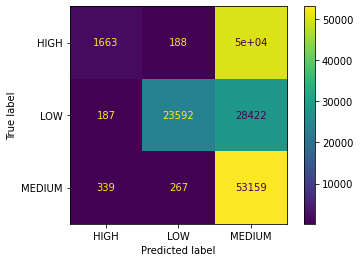

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(labelencoder_y.classes_))

### Categorical Naive Bayes

In [112]:
### Remove these 2 features as they contain negative values, which is not accepted by CategoricalNB

x_train2 = x_train.drop(columns=["extra","improvement_surcharge"])
x_test2 = x_test.drop(columns=["extra","improvement_surcharge"])

n_splits=5
cnb_model = CategoricalNB(min_categories=3)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(cnb_model, x_train2, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(cnb_model, x_train2, y_train, cv=cv_strat_kfold)
cnb_model.fit(x_train2, y_train)
cnb_unscaled_res_train = cnb_model.score(x_train2, y_train)
cnb_unscaled_res_test = cnb_model.score(x_test2, y_test)
print("Categorical Naive Bayes with no scaling.")
print(f"Train Set Accuracy: {cnb_unscaled_res_train*100:.2f}%")
print(f"Test Set Accuracy: {cnb_unscaled_res_test*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.nanmean(cv_kfold_res):.2f} with std {np.nanstd(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.nanmean(cv_strat_kfold_res):.2f} with std {np.nanstd(cv_strat_kfold_res):.2f}")
print()

Categorical Naive Bayes with no scaling.
Train Set Accuracy: 76.39%
Test Set Accuracy: 76.43%
Cross Validation using KFold Sampling Mean: 0.76 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.76 with std 0.00



In [113]:
cnb_model.fit(x_train2, y_train)
y_pred = cnb_model.predict(x_test2)
print(classification_report(y_test, y_pred, target_names=list(labelencoder_y.classes_)))
del x_train2, x_test2

              precision    recall  f1-score   support

        HIGH       0.89      0.75      0.81     52195
         LOW       0.83      0.78      0.80     52201
      MEDIUM       0.63      0.76      0.69     53765

    accuracy                           0.76    158161
   macro avg       0.78      0.76      0.77    158161
weighted avg       0.78      0.76      0.77    158161



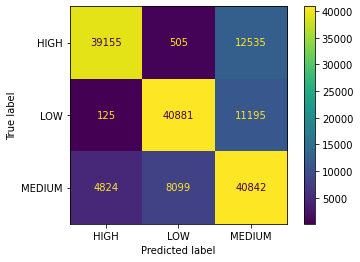

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=list(labelencoder_y.classes_))

# Logistic Regression

In [37]:
n_splits=5
C=1
penalty="l2"
solver = "lbfgs"

lr_model = LogisticRegression(n_jobs=-1, C=C, penalty=penalty, solver=solver)
cv_kfold = KFold(n_splits=n_splits)
cv_strat_kfold = StratifiedKFold(n_splits=n_splits)
cv_kfold_res = cross_val_score(lr_model, x_train, y_train, cv=cv_kfold)
cv_strat_kfold_res = cross_val_score(lr_model, x_train, y_train, cv=cv_strat_kfold)
lr_unscaled_res = lr_model.fit(x_train, y_train).score(x_test, y_test)
print(f"Logistic Regression using {penalty} regularization with {C} strength, {solver} solver and no scaling. Accuracy: {lr_unscaled_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_res):.2f} with std {np.std(cv_kfold_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_res):.2f} with std {np.std(cv_strat_kfold_res):.2f}")
print()

lr_std_res = lr_model.fit(x_std_train, y_train).score(x_std_test, y_test)
print(f"Logistic Regression using {penalty} regularization with {C} strength, {solver} solver and Standard scaling. Accuracy: {lr_std_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_std_res):.2f} with std {np.std(cv_kfold_std_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_std_res):.2f} with std {np.std(cv_strat_kfold_std_res):.2f}")
print()

lr_minmax_res = lr_model.fit(x_minmax_train, y_train).score(x_minmax_test, y_test)
print(f"Logistic Regression using {penalty} regularization with {C} strength, {solver} solver and Minmax scaling. Accuracy: {lr_minmax_res*100:.2f}%")
print(f"Cross Validation using KFold Sampling Mean: {np.mean(cv_kfold_minmax_res):.2f} with std {np.std(cv_kfold_minmax_res):.2f}")
print(f"Cross Validation using StratifiedKFold Sampling Mean: {np.mean(cv_strat_kfold_minmax_res):.2f} with std {np.std(cv_strat_kfold_minmax_res):.2f}")

Logistic Regression using l2 regularization with 1 strength, lbfgs solver and no scaling. Accuracy: 76.10%
Cross Validation using KFold Sampling Mean: 0.76 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.76 with std 0.01

Logistic Regression using l2 regularization with 1 strength, lbfgs solver and Standard scaling. Accuracy: 80.64%
Cross Validation using KFold Sampling Mean: 0.50 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.50 with std 0.00

Logistic Regression using l2 regularization with 1 strength, lbfgs solver and Minmax scaling. Accuracy: 79.11%
Cross Validation using KFold Sampling Mean: 0.50 with std 0.00
Cross Validation using StratifiedKFold Sampling Mean: 0.50 with std 0.00


### No Scaling

In [ ]:
penalty = [None, "l2", "l1", "elasticnet"]
C = [0.01, 0.1, 0.5, 1, 10]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
###########
# The liblinear solver supports both L1 and L2 regularization.
# The newton-cg, sag, and lbfgs solvers support only L2 or no regularization.
# The Elastic-Net regularization is only supported by the saga solver.
###########
search_params = [
    {'penalty': ["l2", "l1"],
      'C': C,
      'solver': ["liblinear"]},
    {'penalty': ["l2"],
      'C': C,
      'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': [None],
     'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': ["l1", "elasticnet"],
      'C': C,
      'solver': ["saga"]},
    ]

lr_model = LogisticRegression(n_jobs=-1)
#search_params = {"penalty":penalty, "C":C, "solver":solver}
lr_unscaled_res = GridSearchCV(lr_model, search_params, n_jobs=5, verbose=1).fit(x_train, y_train)

print("Best Parameters achieved at:")
for k,v in lr_unscaled_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {lr_unscaled_res.best_score_*100:.2f}%")
plot_search_results(lr_unscaled_res)

In [21]:
print("Best Parameters achieved at:")
for k,v in lr_unscaled_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with no scaling. Accuracy {lr_unscaled_res.best_score_*100:.2f}%")

Best Parameters achieved at:
 - C = 0.01
 - penalty = None
 - solver = newton-cg
with no scaling. Accuracy 80.44%


In [25]:
penalty = lr_unscaled_res.best_params_["penalty"]
C = lr_unscaled_res.best_params_["C"]
solver = lr_unscaled_res.best_params_["solver"]
lr_model = LogisticRegression(penalty=penalty, C=C, solver=solver, n_jobs=-1)
lr_model.fit(x_train, y_train)
train_score = lr_model.score(x_train, y_train)
test_score = lr_model.score(x_test, y_test)
print(f"Logistic Regression using {penalty} penalty, {C} inverse regularization strength, {solver} solver and no scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

c:\users\karim\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic Regression using None penalty, 0.01 inverse regularization strength, newton-cg solver and no scaling.
Training Set Accuracy: 80.43%
Test Set Accuracy: 80.41%


### Standard Scaling

In [ ]:
penalty = [None, "l2", "l1", "elasticnet"]
C = [0.01, 0.1, 0.5, 1, 10]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
###########
# The liblinear solver supports both L1 and L2 regularization.
# The newton-cg, sag, and lbfgs solvers support only L2 or no regularization.
# The Elastic-Net regularization is only supported by the saga solver.
###########
search_params = [
    {'penalty': ["l2", "l1"],
      'C': C,
      'solver': ["liblinear"]},
    {'penalty': ["l2"],
      'C': C,
      'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': [None],
     'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': ["l1", "elasticnet"],
      'C': C,
      'solver': ["saga"]},
    ]

lr_model = LogisticRegression(n_jobs=-1)
#search_params = {"penalty":penalty, "C":C, "solver":solver}
lr_std_res = GridSearchCV(lr_model, search_params, n_jobs=5, verbose=1).fit(x_std_train, y_train)

In [34]:
print("Best Parameters achieved at:")
for k,v in lr_std_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Standard scaling. Accuracy {lr_std_res.best_score_*100:.2f}%")
#plot_search_results(lr_std_res)

Best Parameters achieved at:
 - penalty = None
 - solver = lbfgs
with Standard scaling. Accuracy 80.44%


In [30]:
penalty = lr_std_res.best_params_["penalty"]
#C = lr_std_res.best_params_["C"]
solver = lr_std_res.best_params_["solver"]
lr_model = LogisticRegression(penalty=penalty, solver=solver, n_jobs=-1)
lr_model.fit(x_std_train, y_train)
train_score = lr_model.score(x_std_train, y_train)
test_score = lr_model.score(x_std_test, y_test)
print(f"Logistic Regression using {penalty} penalty, {solver} solver and Standard scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

Logistic Regression using None penalty, lbfgs solver and Standard scaling.
Training Set Accuracy: 80.43%
Test Set Accuracy: 80.41%


### Minmax Scaling

In [ ]:
penalty = [None, "l2", "l1", "elasticnet"]
C = [0.01, 0.1, 0.5, 1, 10]
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
###########
# The liblinear solver supports both L1 and L2 regularization.
# The newton-cg, sag, and lbfgs solvers support only L2 or no regularization.
# The Elastic-Net regularization is only supported by the saga solver.
###########
search_params = [
    {'penalty': ["l2", "l1"],
      'C': C,
      'solver': ["liblinear"]},
    {'penalty': ["l2"],
      'C': C,
      'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': [None],
     'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]},
    {'penalty': ["l1", "elasticnet"],
      'C': C,
      'solver': ["saga"]},
    ]

lr_model = LogisticRegression(n_jobs=-1)
#search_params = {"penalty":penalty, "C":C, "solver":solver}
lr_minmax_res = GridSearchCV(lr_model, search_params, n_jobs=5, verbose=1).fit(x_minmax_train, y_train)

In [33]:
print("Best Parameters achieved at:")
for k,v in lr_minmax_res.best_params_.items():
    print(f" - {k} = {v}")
print(f"with Minmax scaling. Accuracy {lr_minmax_res.best_score_*100:.2f}%")
#plot_search_results(lr_minmax_res)

Best Parameters achieved at:
 - penalty = None
 - solver = sag
with Minmax scaling. Accuracy 80.47%


In [32]:
penalty = lr_minmax_res.best_params_["penalty"]
#C = lr_minmax_res.best_params_["C"]
solver = lr_minmax_res.best_params_["solver"]
lr_model = LogisticRegression(penalty=penalty, solver=solver, n_jobs=-1)
lr_model.fit(x_minmax_train, y_train)
train_score = lr_model.score(x_minmax_train, y_train)
test_score = lr_model.score(x_minmax_test, y_test)
print(f"Logistic Regression using {penalty} penalty, {solver} solver and Minmax scaling.")
print(f"Training Set Accuracy: {train_score*100:.2f}%")
print(f"Test Set Accuracy: {test_score*100:.2f}%")

Logistic Regression using None penalty, sag solver and Minmax scaling.
Training Set Accuracy: 80.33%
Test Set Accuracy: 80.30%


# Conclusion

## K Nearest Neighbors

Optimizing on the test set, the chosen value for K was K=9 yielding an accuracy of about 74.6%.
Optimizing on the CV set, the chosen set of paramters was (metric = manhattan, n_neighbors = 10, weights = distance) with a CV accuracy of almost 72%.
However it seems that the KNN model is significantly overfit as testing on the training data yields an accuracy of 99.9%, which is significantly far from both the test and CV sets.

Unfortunately, due to computational power and time constraints, the effect of normalization could not be properly explored for the choice of parameters. However, using the best parameters for the unscaled data on the scaled datset, Standard Scaling seems to yield better results, so it could be the case that KNN might be a viable model if Standard Scaling is applied to the data beforehand. Minmax scaling however seems to worsen the model further.

Overall, we do **NOT** reccommend KNN as a model for this set, especially considering how intensive it is at the test / prediction phase.

## Decision Trees

Using Cross Validation, it was found that the best parameters were (criterion = gini, max_depth = 12, max_features = None). Regularization was included in the parameter search so as to find the best accuracy while still not being too overfit.

The CV accuracy was 82.80%, the train set accuracy was 83.83%, and the test set accuracy was 82.98%.
As all the values are very close together, we believe this to be a very good outcome for a decision tree, yielding good accuracy values while not being overfit. Scaling the data beforehand seems to have minimal effect on the output provided by the tree

Overall, we can recommend Decision Trees as a model for this set.

## Random Forest

The results for the Random Forest Classifier seem to be very close to those provided by the Decision Tree Classifer.

The best parameters, according to the CV set, are achieved at (criterion = gini, max_depth = 10, max_features = None, n_estimators = 67). This is the same parameters set as the Decision Trees, however, the max_depth was restricted during the search to a lower peak value, due to the fact that we now have more trees, hence 10 instead of 12. Furthermore, the model suggests 67 trees, however, according to the CV graphs, this variance between values is relatively insignificant as long as it is above 10 trees.

The CV accuracy was reported to be 83.08% with a training set accuracy of 83.35% and a test set accuracy of 83.02%. As they are all around the 83% point, we conclude that the regularization of the max_depth was enough to stop the model from overfitting to the trained data. Scaling also had minimal effect on this model, as with Decision Trees.

Overall, we recommend Random Forest Classifiers **the most** as a model for this set.

## Naive Bayes

For Naive Bayes, we tested two models. Namely, Gaussian Naive Bayes and Categorical Naive Bayes.

For Gaussian Naive Bayes, we observed a train set accuracy of 49.68% and a test set accuracy of 49.58%. This corresponds to a significantly low bias, where the model is severely underfit, barely performing better than a completely random guessing model (Which should achieve accuracy ~33%).
Looking at the confusion matrix, we see that a very significant portion of members of the High Price category were misclassified as members of the Medium Price category.
We think that the reason behind the failure of this model is due to the fact that most features in our dataset are not Gaussian distributed, and that some features may be correlated / dependant, which goes against the assumption by the Naive Bayes' model.

For Categorical Naive Bayes, we were able to achieve significantly better (albeit still relatively bad!) results, with a train set accuracy of 76.39% and a test set accuracy of 76.43%. If we look at the confusion matrix, we see that the High Price category is no longer misclassified that much as Medium when compared to Gaussian Naive Bayes. Furthermore, looking at the classification report, we can confirm this by comparing Gaussian Naive Bayes' Precision and Recall values with Categorical Naive Bayes' Precision and Recall values. We observe that they changed from (0.76, 0.03) to (0.89, 0.75).
We assume this is due to the fact that most features in our dataset are categorical and/or binary in nature, which fit a categorical model more than a Gaussian model.

Overall, we do **NOT** recommend Naive Bayes **at all** as a model for this set.

## Logistic Regression

For Logistic Regression, using CV for choosing the parameters, we ended up with the best parameters being (penalty = None, solver = newton-cg) with a CV accuracy of 80.44%.
Penalty = None means that the model does not use any regularization scheme (L2/L1/elasticnet). Despite that however, we observe that the model is not overfit as the training set accuracy was 80.43% and the test set accuracy was 80.41%.
As all the values are close to 80.4%, we conclude that regularization may not be necessary for this current training dataset.

Overall, we think Logistic Regression is an *acceptable* model, however Decision Trees or Random Forests should be considered first.